# Numerics of MD

## Test problem

\begin{align*}
& \min_x \|Ax - b\|_1\\
\text{s.t. } & x \in \Delta
\end{align*}

- Subgradient $g = \sum_{i=1}^m sign(a_i^{\top}x - b) a_i$
- Projected subgradient descent $(\varphi(x) = \frac12\|x\|^2_2)$
$$
x_{k+1} = \arg\min_{x \in \Delta} (\langle g_k, x\rangle + \frac{1}{2\alpha_k}\|x - x_k\|_2^2)
$$
Algorithm for computing projection onto simplex is provided [here](https://arxiv.org/pdf/1101.6081.pdf)
- Entropic descent $(\varphi(x) = \sum_{i=1}^n x_i \log x_i)$
$$
x^i_{k+1} = \frac{x_k^i \exp(-\alpha_k g(x_k)_i)}{\sum_{j=1}^n x_k^j \exp(-\alpha_k g(x_k)_j)}
$$

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import cvxpy as cvx
from numba import jit

In [11]:
def entropic_descent(subgrad, x0, step_size=None, max_iter=100):
    x = x0.copy()
    conv = [x]
    for i in range(max_iter):
        g = subgrad(x)
        if step_size is None:
            alpha = 1. / (i + 1)
        else:
            alpha = step_size
        x = x * np.exp(-alpha * g) / np.sum(x * np.exp(-alpha * g))
        conv.append(x)
    return x, conv

In [12]:
@jit(nopython=True)
def proj(y):
    x = y.copy()
    if np.all(x >= 0) and np.sum(x) <= 1:
        return x
    x[x < 0] = 0
    if np.sum(x) <= 1:
        return x
    n = x.shape[0]
    bget = False
    x.sort()
    x = x[::-1]
    temp_sum = 0
    for i in range(n - 1):
        temp_sum += x[i]
        t_hat = (temp_sum - 1.0) / (i + 1)
        if t_hat >= x[i + 1]:
            bget = True
            break
    if not bget:
        t_hat = (temp_sum + x[n - 1] - 1.0) / n
    return np.maximum(y - t_hat, 0)

In [14]:
def proj_subgrad(subgrad, proj, x0, step_size=None, max_iter=100):
    x = x0.copy()
    conv = [x]
    for i in range(max_iter):
        g = subgrad(x)
        if step_size is None:
            alpha = 1. / (i+1) 
        else:
            alpha = step_size
        x = proj(x - alpha * g)
        conv.append(x)
    return x, conv

In [15]:
m = 20
n = 3000
A = np.random.randn(m, n)
# x_true = np.random.rand(n)
# x_true = x_true / np.linalg.norm(x_true, 1)
x_true = np.zeros(n)
x_true[0] = 0.5
x_true[1] = 0.5
b = A.dot(x_true)
# b = 0.5 * (A[:, 0] + A[:, 1])

In [49]:
x0 = np.ones(n) / n
max_iter = 7000
step_size_md = 1e-3
step_size_sg = 1e-4

In [50]:
subgrad = lambda x: np.sum(A.T * np.sign(A.dot(x) - b), axis=1)
f = lambda x: np.linalg.norm(A.dot(x) - b, 1)

In [51]:
x_entr, conv_entr = entropic_descent(subgrad, x0, step_size_md, max_iter)
print(np.linalg.norm(x_entr, 1))
x_subgr, conv_projsub = proj_subgrad(subgrad, proj, x0, step_size_sg, max_iter)
print(np.linalg.norm(x_subgr, 1))

1.0
0.9999999999999994


(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 <a list of 6 Text yticklabel objects>)

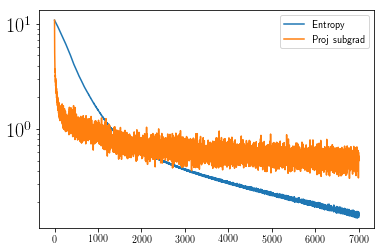

In [52]:
plt.semilogy([f(x) for x in conv_entr], label="Entropy")
plt.semilogy([f(x) for x in conv_projsub], label="Proj subgrad")
plt.legend()
plt.yticks(fontsize=20)

(array([ 0.01,  0.1 ,  1.  , 10.  ]), <a list of 4 Text yticklabel objects>)

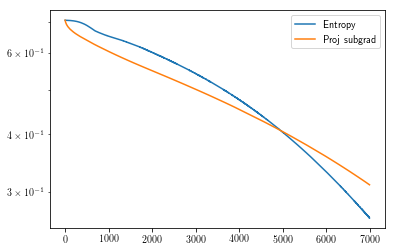

In [53]:
plt.semilogy([np.linalg.norm(x - x_true) for x in conv_entr], label="Entropy")
plt.semilogy([np.linalg.norm(x - x_true) for x in conv_projsub], label="Proj subgrad")
plt.legend()
plt.yticks(fontsize=20)

In [22]:
x_subgr, x_entr

(array([0.4438896 , 0.42898022, 0.        , ..., 0.        , 0.        ,
        0.        ]),
 array([4.09961337e-01, 3.71339285e-01, 5.44518488e-39, ...,
        2.80750448e-18, 8.34433807e-37, 9.13457504e-38]))